In [45]:
import collections
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import shutil
import os
import io
import json
import requests 
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.layers import Dense, Activation 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model 
from tensorflow.keras.models import Sequential 

from matplotlib.pyplot import figure, show
%matplotlib inline

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs which is numpy array 
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    
    #Tensorflow only support numpy array for now 
    
    #if output column is integer that means the problem is classification problem
    #in this case, tensorflow wants output to be 1hot encoding 
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target]) #1 hot encoding 
        # call dataframe.values to convert dataframe to numpy array 
        # return 2 value , X and Y 
        # first return value is the X matrix convert to np
        # second return value is the Y matrix after 1 hot encoding and convert to np 
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    plt.figure(figsize=(20,10))
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction',color='b')
    a = plt.plot(t['y'].tolist(),label='expected',linewidth=3.0,color='r')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


# Read file , fill missing value with NA 
def readfile(filename):
    path = "./data/"
    return pd.read_csv(os.path.join(path,filename) , na_values=['NA','?'])



### Load business.json -> business.tsv

In [4]:
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','name', 'stars' , 'review_count' , 'latitude' , 'longitude'])

with open('business.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
         # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], 
                       (row['name']).encode('utf-8'), 
                        row['stars'], 
                        row['review_count'],
                        row['latitude'],
                        row['longitude']])

outfile.close()

### Load review.json -> review.tsv

In [5]:
outfile = open("review.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])

with open('review.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

### Prepare Input table

In [6]:
#load business.tsv 
business_df = pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")

In [7]:
#load review_stars.tsv and sum reviews 
review_df = pd.read_csv('review.tsv', delimiter ="\t", encoding="utf-8")

In [8]:
# Group review by business_id to numpy array
df_review_agg = review_df.groupby('business_id')['text'].sum()

In [9]:
#Convert df_review_agg to dataframe
df_ready_for_sklearn = pd.DataFrame( {'business_id': df_review_agg.index, 
                                      'all_reviews' : df_review_agg.values,})

In [10]:
df_ready_for_sklearn.head()

,business_id,all_reviews
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...


In [11]:
#Combine df_ready_for_sklearn with business_df to be the "final table" : final table serve as the input table.
final = pd.merge(df_ready_for_sklearn , business_df  , on='business_id' , how='inner')

In [12]:
final.head()

,business_id,all_reviews,name,stars,review_count,latitude,longitude
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',4.0,24,51.049673,-114.079977
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...","b""John's Chinese BBQ Restaurant""",3.0,44,43.841694,-79.399755
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',4.0,58,35.437106,-80.843688
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...,b'Valley Bone and Joint Specialists',3.5,4,33.378589,-111.748145
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,b'Great Clips',3.5,12,33.362813,-111.908995


In [13]:
#Drop all business < 10 review count 
final = final[final.review_count >= 10]

In [14]:
#Save final to csv 
final.to_csv('final.csv', index=False) 

In [15]:
final.shape 

(92592, 7)

### Step 1 : Read from final.csv that is the input data

In [2]:
%%time
final = pd.read_csv('final.csv', na_values=['NA','?'])

Wall time: 26.4 s


In [13]:
final.head()

,business_id,all_reviews,name,stars,review_count,latitude,longitude
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',4.0,24,51.049673,-114.079977
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...","b""John's Chinese BBQ Restaurant""",3.0,44,43.841694,-79.399755
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',4.0,58,35.437106,-80.843688
3,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,b'Great Clips',3.5,12,33.362813,-111.908995
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,b'Delmonico Steakhouse',4.0,1613,36.123183,-115.169190


### Step 2 :Preprocess

In [3]:
#Remove column with no prediction power 
final.drop(['business_id' ,'name' , 'review_count'],axis=1,inplace=True)

In [4]:
#Missing Median
missing_median(final, 'latitude')
missing_median(final, 'longitude')

In [5]:
#Encoding / Normalize input feature
encode_numeric_zscore(final, 'latitude')
encode_numeric_zscore(final, 'longitude')

In [6]:
%%time
# Get important words 
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                                    max_features = 5000,
                                    min_df = 1
                                    )
matrix = vectorizer.fit_transform(final.all_reviews)
tfidf_data = matrix.toarray()

print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['00', '000', '00pm', '10', '100', '1000', '10am', '10pm', '11', '11am', '11pm', '12', '120', '13', '14', '15', '150', '16', '17', '18', '19', '1pm', '1st', '20', '200', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '21', '22', '23', '24', '25', '250', '26', '27', '28', '29', '2nd', '2pm', '30', '300', '30am', '30pm', '32', '35', '36', '3pm', '3rd', '40', '400', '45', '48', '49', '4pm', '4th', '50', '500', '55', '5pm', '5th', '60', '65', '6pm', '70', '75', '7pm', '7th', '80', '800', '85', '8pm', '90', '95', '99', '9am', '9pm', 'ability', 'able', 'absolute', 'absolutely', 'ac', 'accent', 'accept', 'acceptable', 'accepted', 'access', 'accessible', 'accessories', 'accident', 'accidentally', 'accommodate', 'accommodated', 'accommodating', 'accompanied', 'according', 'accordingly', 'account', 'accurate', 'acknowledge', 'acknowledged', 'acrylic', 'act', 'acted', 'acting', 'action', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'addict

In [7]:
final.columns

Index(['all_reviews', 'stars', 'latitude', 'longitude'], dtype='object')

In [8]:
# this column is no longer needed and should be replace with the vectorized version of "all_reviews"
final.drop('all_reviews', axis=1 , inplace=True)

In [9]:
final.columns = ['Star_rating' , 'latitude' , 'longitude'] 

In [10]:
final.head() , final.shape

(   Star_rating  latitude  longitude
 0          4.0  2.836803  -0.889228
 1          3.0  1.280054   1.215488
 2          4.0 -0.535133   1.127857
 3          3.5 -0.983130  -0.757473
 4          4.0 -0.386957  -0.955332, (92592, 3))

In [11]:
# Composed = dataframe of the tfidf_data 
composed = pd.DataFrame(tfidf_data, columns=vectorizer.get_feature_names()) #Convert numpy to df 

In [12]:
composed.columns , composed.shape

(Index(['00', '000', '00pm', '10', '100', '1000', '10am', '10pm', '11', '11am',
        ...
        'young', 'younger', 'yr', 'yuck', 'yum', 'yummy', 'zero', 'zone', 'zoo',
        'zucchini'],
       dtype='object', length=5000), (92592, 5000))

In [13]:
%%time
train_ready = pd.merge(final,composed, on=final.index , how='inner')

Wall time: 7.4 s


In [14]:
train_ready.columns

Index(['key_0', 'Star_rating', 'latitude', 'longitude', '00', '000', '00pm',
       '10', '100', '1000',
       ...
       'young', 'younger', 'yr', 'yuck', 'yum', 'yummy', 'zero', 'zone', 'zoo',
       'zucchini'],
      dtype='object', length=5004)

In [15]:
train_ready = train_ready.drop(train_ready.columns[0] , axis='columns')

In [16]:
train_ready.columns

Index(['Star_rating', 'latitude', 'longitude', '00', '000', '00pm', '10',
       '100', '1000', '10am',
       ...
       'young', 'younger', 'yr', 'yuck', 'yum', 'yummy', 'zero', 'zone', 'zoo',
       'zucchini'],
      dtype='object', length=5003)

In [19]:
%%time
header = train_ready.columns
train_ready.to_csv('split_ready.csv' , columns = header)

Wall time: 5min 6s


In [35]:
%%time
train_ready = pd.read_csv('split_ready.csv', encoding="utf-8")

Wall time: 1min 40s


In [36]:
train_ready.head()

,Unnamed: 0,Star_rating,latitude,longitude,00,000,00pm,10,100,1000,...,young,younger,yr,yuck,yum,yummy,zero,zone,zoo,zucchini
0,0,4.0,2.836803,-0.889228,0.000000,0.000000,0.000000,0.008603,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015732,0.000000,0.0,0.0
1,1,3.0,1.280054,1.215488,0.025712,0.000000,0.000000,0.013500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009884,0.0,0.0
2,2,4.0,-0.535133,1.127857,0.000000,0.000000,0.000000,0.011883,0.000000,0.000000,...,0.006239,0.009839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3,3.5,-0.983130,-0.757473,0.000000,0.000000,0.000000,0.000000,0.023909,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028374,0.000000,0.0,0.0
4,4,4.0,-0.386957,-0.955332,0.005172,0.000966,0.001413,0.011517,0.008033,0.001749,...,0.001719,0.000903,0.001859,0.000338,0.010108,0.013371,0.001109,0.000000,0.0,0.0


In [37]:
rating = train_ready.Star_rating

In [38]:
train_ready = train_ready.drop(train_ready.columns[0] , axis='columns')
train_ready = train_ready.drop(train_ready.columns[0] , axis='columns')

In [39]:
train_ready.head()

,latitude,longitude,00,000,00pm,10,100,1000,10am,10pm,...,young,younger,yr,yuck,yum,yummy,zero,zone,zoo,zucchini
0,2.836803,-0.889228,0.000000,0.000000,0.000000,0.008603,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015732,0.000000,0.0,0.0
1,1.280054,1.215488,0.025712,0.000000,0.000000,0.013500,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009884,0.0,0.0
2,-0.535133,1.127857,0.000000,0.000000,0.000000,0.011883,0.000000,0.000000,0.0,0.000000,...,0.006239,0.009839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,-0.983130,-0.757473,0.000000,0.000000,0.000000,0.000000,0.023909,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028374,0.000000,0.0,0.0
4,-0.386957,-0.955332,0.005172,0.000966,0.001413,0.011517,0.008033,0.001749,0.0,0.001328,...,0.001719,0.000903,0.001859,0.000338,0.010108,0.013371,0.001109,0.000000,0.0,0.0


In [30]:
#Split to test/train 
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(train_ready,rating,np.arange(rating.shape[0]),test_size=0.20,random_state=42)

In [31]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape , train_ready.shape , rating.shape

((74073, 5002), (18519, 5002), (74073,), (18519,), (92592, 5002), (92592,))

### Step 3: Create Model + Training 

In [43]:
%%time
checkpointer = ModelCheckpoint(filepath="saved/projectBestSave.hdf5", verbose=0, save_best_only=True)

for i in range(50):
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>' , i)
    #build model
    model = Sequential()
    model.add(Dense(25, input_dim=train_ready.shape[1], activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(7,  activation='sigmoid'))
    model.add(Dense(15, activation='sigmoid'))
    model.add(Dense(1))
    
    #Compile model 
    model.compile(loss='mean_squared_error' , optimizer='adam')
    
    #Early Stopping
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')
    
    #Training
    model.fit(x_train, y_train,
              validation_data=(x_test,y_test),
              batch_size=32,
              callbacks=[monitor,checkpointer],
              verbose=2,
              epochs=1000)
#Load Best Model 
model.load_weights('saved/projectBestSave.hdf5')
print("Best Model Loaded...")

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0
Train on 74073 samples, validate on 18519 samples
Epoch 1/1000
74073/74073 - 29s - loss: 1.1792 - val_loss: 0.1862
Epoch 2/1000
74073/74073 - 26s - loss: 0.1108 - val_loss: 0.0946
Epoch 3/1000
74073/74073 - 25s - loss: 0.0841 - val_loss: 0.0885
Epoch 4/1000
74073/74073 - 25s - loss: 0.0794 - val_loss: 0.0901
Epoch 5/1000
74073/74073 - 24s - loss: 0.0765 - val_loss: 0.0863
Epoch 6/1000
74073/74073 - 24s - loss: 0.0746 - val_loss: 0.0858
Epoch 7/1000
74073/74073 - 25s - loss: 0.0731 - val_loss: 0.0865
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 1
Train on 74073 samples, validate on 18519 samples
Epoch 1/1000
74073/74073 - 26s - loss: 1.6198 - val_loss: 0.7343
Epoch 2/1000
74073/74073 - 25s - loss: 0.4628 - val_loss: 0.1067
Epoch 3/1000
74073/74073 - 24s - loss: 0.0924 - val_loss: 0.0911
Epoch 4/1000
74073/74073 - 26s - loss: 0.0825 - val_loss: 0.0892
Epoch 5/1000
74073/74073 - 25s - loss: 0.0785 - val_loss: 0.0880
Epoch 6/

### Step4: Predict and Performance

In [ ]:
model = Sequential()
model.load_weights('saved/projectBestSave.hdf5')
print("Best Model Loaded...")

In [44]:
# save entire network to HDF5 (save everything)

model.save('saved/projectBestSave.hdf5')

In [ ]:
# Load model if don't want to recompute model 
model = load_model('saved/projectBestSave.hdf5')

In [46]:
model.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_594 (Dense)            (None, 25)                125075    
_________________________________________________________________
dense_595 (Dense)            (None, 10)                260       
_________________________________________________________________
dense_596 (Dense)            (None, 50)                550       
_________________________________________________________________
dense_597 (Dense)            (None, 7)                 357       
_________________________________________________________________
dense_598 (Dense)            (None, 15)                120       
_________________________________________________________________
dense_599 (Dense)            (None, 1)                 16        
Total params: 126,378
Trainable params: 126,378
Non-trainable params: 0
_______________________________________________

In [47]:
pred = model.predict(x_test) 

In [48]:
import numpy
numpy.savetxt('x_test.csv', x_test, delimiter=",")

In [49]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.292230016721468


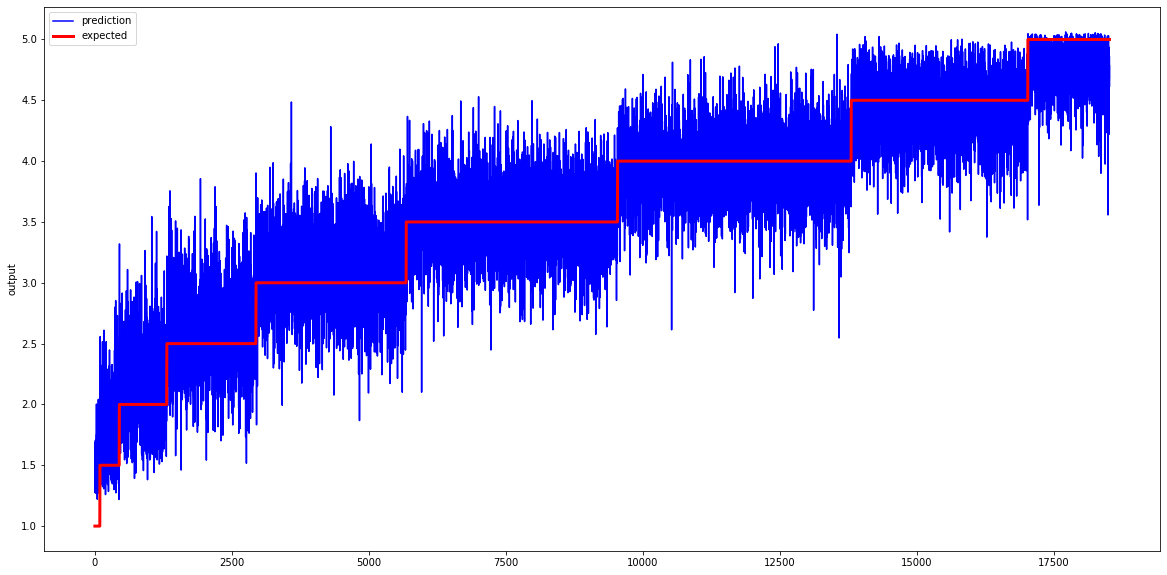

In [50]:
chart_regression(pred.flatten(),y_test.values.flatten(), sort=True)

In [51]:
final = pd.read_csv('final.csv', na_values=['NA','?']) # Can Skip ? No.

In [52]:
#Create df with only indices_test Add predicted rating 
foo = pd.DataFrame( {'final' : indices_test})
foo['y_test'] = foo.index
foo['pr'] = pred
foo = foo.sort_values(by='final', ascending=True)

In [53]:
#join 2 columns 
done = pd.merge(foo,final, left_on='final' , right_on=final.index) 

In [54]:
result = pd.concat([done.name,done.stars,done.pr] , axis=1)

In [55]:
result = result.sort_values(by='name' , ascending=False)

In [56]:
result

,name,stars,pr
599,b'z-teca Gourmet Burritos',2.5,2.373703
4519,b'west elm',3.5,3.334174
1346,b'west elm',3.5,3.515415
11769,b'urbAna',5.0,4.790074
4190,b'unPhogettable',4.0,4.184767
3076,b'uFly Simulator',4.5,4.651718
14354,b'uBreakiFix',4.0,4.070764
2825,b'uBreakiFix',4.5,4.255729
2202,b'uBreakiFix',4.0,4.161150
13179,b'uBreakiFix',4.5,4.244125
